# Requirements

In [1]:
from google.colab import drive

from os import listdir
from os.path import isfile, join
import os.path
from os import path

import tarfile
import glob

import tensorflow as tf
import sklearn 
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import io

import PIL
from PIL import Image
import cv2
import seaborn as sns

In [2]:
drive.mount('/content/gdrive', force_remount=True)
PATH_PROJ = "/content/gdrive/MyDrive/AML-proj/" 
if not path.exists(PATH_PROJ):
    PATH_PROJ = "/content/gdrive/Shareddrives/AML-proj/"  # TODO: check if it is correct!

PATH_JPG = "/content/jpg/"
PATH_TAR = PATH_PROJ + "102flowers.tgz"
IMG_SIZE = 224
NUM_CLASSES = 102

NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

NAMES_ID = dict(zip(NAMES, [x for x in range(len(NAMES))]))
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

Mounted at /content/gdrive


# Functions

In [3]:
def execute_pca_on_imgs(img, show=False):
  # Splitting the image in R,G,B arrays.
  b, g, r = cv2.split(img) 
  #it will split the original image into Blue, Green and Red arrays.

  # it is mandatory to do feature scaling before applying PCA because PCA directions are highly sensitive to the relative ranges of features
  r_scaled = r / 255
  g_scaled = g / 255
  b_scaled = b / 255

  #initialize PCA with at least 95% variance  
  pca_r = PCA(0.95)
  pca_r_trans = pca_r.fit_transform(r_scaled)

  pca_g = PCA(0.95)
  pca_g_trans = pca_g.fit_transform(g_scaled)

  pca_b = PCA(0.95)
  pca_b_trans = pca_b.fit_transform(b_scaled)

  # inverse
  pca_r_org = pca_r.inverse_transform(pca_r_trans)
  pca_g_org = pca_g.inverse_transform(pca_g_trans)
  pca_b_org = pca_b.inverse_transform(pca_b_trans)

  # compressiong
  img_compressed = cv2.merge((pca_b_org, pca_g_org, pca_r_org))
  #viewing the compressed image
  if show: 
    plt.imshow(img_compressed)
    plt.show()

  return img_compressed
    

def execute_pca_on_imgs_set(df, path = PATH_JPG):
  for img_name in df["Id"]:
    RGB_img = plt.imread(path + img_name)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_pca = execute_pca_on_imgs(RGB_img)
    cv2.imwrite(PATH_PROJ + "jpg_pca/" + img_name, 255*im_pca, [cv2.IMWRITE_JPEG_QUALITY])
    

def processing_set(dataset, images, labels, size=224, return_pca=False):
  x, y = [], []
  for num_img in dataset:
    # print(f"linking {num_img} to {images[num_img - 1]}")
    path = PATH_JPG + images[num_img - 1]
    im=cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,(size,size))
    x.append(im)
    y.append(labels[num_img - 1])
  
  if return_pca:
    return execute_pca_on_imgs_set(x), np.asarray(y) 
  else:
    return np.asarray(x), np.asarray(y)


def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


def get_img_info(df, path_figure = PATH_JPG):
  w, h = [], []
  for index, path in enumerate(df["Id"].values):
    im = PIL.Image.open(path_figure+ str(path))
    w.append(im.size[0])
    h.append(im.size[1])

  w, h = np.array(w), np.array(h)
  return int(np.average(w)), int(np.average(h))



## Plot Functions

In [4]:
def count_box_plot(unique_elem_dict, title, label):

  list_value=np.array(list(unique_elem_dict.values()))
  fig, ax = plt.subplots()

  # Save the chart so we can loop through the bars below.
  bars = ax.bar(range(len(unique_elem_dict)), list_value, align='center', tick_label=list(unique_elem_dict.keys()))

  # Axis formatting.
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)


  # Add labels and a title.
  ax.set_xlabel('Model type', labelpad=15, color='#333333')
  ax.set_ylabel(label, labelpad=15, color='#333333')
  ax.set_title(title, pad=15, color='#333333',
              weight='bold')

  plt.show()


def plot_figure(df, path_figure = PATH_JPG):
  plt.figure(figsize=(16,12))
  random_image = df.sample(n=21)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(3,7, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()



def plot_figure_by_class(df, class_number, path_figure = PATH_JPG):
  plt.figure(figsize=(12,8))

  random_image = df[df['Category']==class_number].sample(n=4)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(1,4, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()


def plot_history(history):
  pd.DataFrame(history.history).plot(
  figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
  style=["r--", "r--.", "b-", "b-*"])
  plt.show()

# General script

Di seguito si fornisce l'implementazione di uno script in grado di automatizzare l'intera procedura di analisi dei modelli. Si è potuto constatare come i pooling layer fornissero il miglior grado di accuratezza. L'esecuzione dello script è avvenuta in local-host poichè colab non permette la gestione degli errori di saturazione della RAM. Lo script esegue esattamente i medesimi steps descritti in precedenza e salva le informazioni in un dizionario. Da una prima analisi si è potuto constatare come i top-layers fornissero risultati migliori. E' da sottolineare che del primo e del secondo pooling layer non si sono potuti ricavare dati per via della grandezza delle features che ha reso impossibile l'esecuzione anche su macchina locale.

In [5]:
def start_prediction(name_stop_layer, base_mode, x, summary=True):
  model = Model(inputs=base_model.input, outputs=base_model.get_layer(name_stop_layer).output)
  if summary:
    model.summary()
  features = model.predict(x)
  return features

In [6]:
def compute_transfer_learning_for_each_layer(base_model, x_train, x_test):
  
  saved_results = {}
  for layer in base_model.layers:
    layer_name = layer.name
    
    if layer_name.find("pool") == -1: # analyze only pooling layers
      continue

    print(f"Analyze: {layer_name}")
  
    try:
      # start prediction on train and test set
      feature = start_prediction(layer_name, base_model, x_train, summary=False)
      feature_test = start_prediction(layer_name, base_model, x_test, summary=False)

      # flattening
      pca_data = feature.reshape((feature.shape[0], np.prod(feature.shape[1:])))
      pca_test_data = feature_test.reshape((feature_test.shape[0], np.prod(feature_test.shape[1:])))
      
      # IF WE WOULD USE PCA REMEBER THAT WE SHOULD USE SCALING!

      # PCA
      pca = PCA(n_components=0.95)
      feature_reduced = pca.fit_transform(pca_data)
      feature_test_reduced = pca.transform(pca_test_data)
      
      # SVM
      poly_kernel_svm_clf = Pipeline([
      ("scaler", StandardScaler()),
      ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
      ])
      poly_kernel_svm_clf.fit(feature_reduced, y_train)

      # Prediction    
      y_pred = poly_kernel_svm_clf.predict(feature_test_reduced)
      accuracy = accuracy_score(y_test,y_pred)*100
      confusion_mat = confusion_matrix(y_test,y_pred)

      # Printing the results
      print("Accuracy for SVM is:",accuracy)
      print("Confusion Matrix")
      print(confusion_mat)

      saved_results[layer_name] = accuracy
    except:
      saved_results[layer_name] = 0


  return saved_results

  

In [7]:

# remove this comment to execute
%%script false --no-raise-error 
saved_results = compute_transfer_learning_for_each_layer(base_model, x_train, x_test)
print(saved_results)

## Show data

Di seguito si fornisce una rappresentazione grafica dei risultati ottenuti precedentemente. Si può notare come il pooling layer n.5 fornisca i risultati migliori. Si ipotizza che questo comportamento sia dovuto alla prograssiva diminuizione della grandezza delle features durante il passaggio di esse nei diversi pooling layer della VGG16.

In [8]:
%%script false --no-raise-error 
count_box_plot(saved_results,np.array(list(saved_results.values())), "Accuracy Analysis", "Accuracy %")

# Import Data

In [9]:
!rm -r $PATH_JPG # remove old data

rm: cannot remove '/content/jpg/': No such file or directory


In [10]:
# Import Dataset
%%capture
!tar -xvf $PATH_TAR -C '/content/'
images = [f for f in listdir(PATH_JPG) if isfile(join(PATH_JPG, f))]
images = sorted(images)

df = pd.DataFrame()
df['Id'] = images
df['Category'] = scipy.io.loadmat(PATH_PROJ + 'imagelabels.mat')['labels'][0] - 1 
df['Category'] = df['Category'].astype(int)
#df.head(5)

In [11]:
# Split Dataset con le rispettive label
split = scipy.io.loadmat(PATH_PROJ + 'setid.mat')
test_split = split["tstid"][0] - 1 # start from zero
train_split = split["trnid"][0] - 1
valid_split = split["valid"][0] - 1

train_set = df.iloc[train_split]
train_set['Category'].astype(int)
test_set = df.iloc[test_split]
test_set['Category'].astype(int)
val_set = df.iloc[valid_split]
val_set['Category'].astype(int)
print("Train set:", train_set.shape, "   Validation set:", val_set.shape, "   Test set:", test_set.shape)

Train set: (1020, 2)    Validation set: (1020, 2)    Test set: (6149, 2)


# Analisi Dataset

Analizziamo le distribuzioni dei campioni immagini nei vari set in modo da avere una visione generale sul bilanciamento delle classi

## Take a Quick Look at the Data Structure

In [ ]:
display(train_set.head())
train_set.info()

,Id,Category
6764,image_06765.jpg,0
6754,image_06755.jpg,0
6767,image_06768.jpg,0
6735,image_06736.jpg,0
6743,image_06744.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 6764 to 8040
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1020 non-null   object
 1   Category  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
display(test_set.head())
test_set.info()

,Id,Category
6733,image_06734.jpg,0
6734,image_06735.jpg,0
6736,image_06737.jpg,0
6741,image_06742.jpg,0
6742,image_06743.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6149 entries, 6733 to 8046
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6149 non-null   object
 1   Category  6149 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 144.1+ KB


In [ ]:
display(val_set.head())
val_set.info()

,Id,Category
6772,image_06773.jpg,0
6766,image_06767.jpg,0
6738,image_06739.jpg,0
6748,image_06749.jpg,0
6762,image_06763.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 6772 to 8029
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1020 non-null   object
 1   Category  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
average_resolution = get_img_info(df) # average resolution img

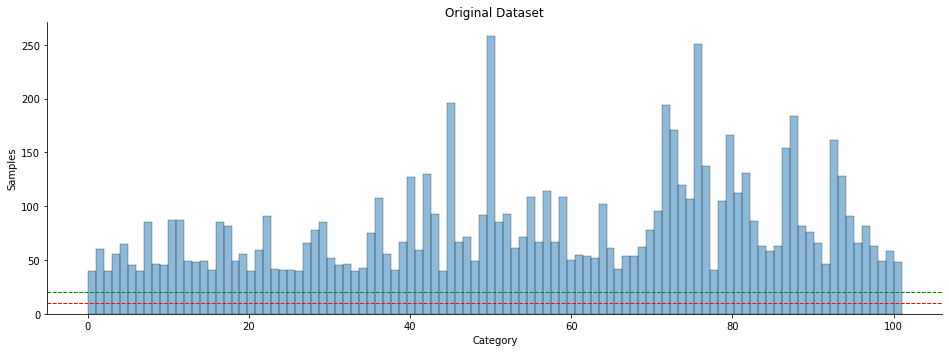

In [ ]:
distribuzione = sns.displot(df, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Original Dataset')

distribuzione.refline(y = 10,
          color = "red",
          lw = 1)
distribuzione.refline(y = 20,
          color = "green",
          lw = 1)

distribuzione.fig.set_size_inches(15,5)

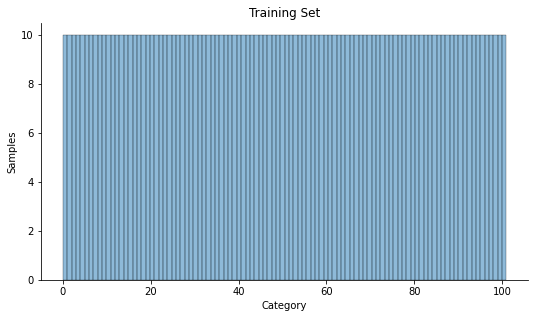

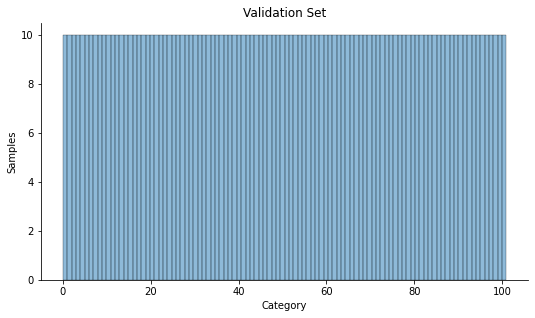

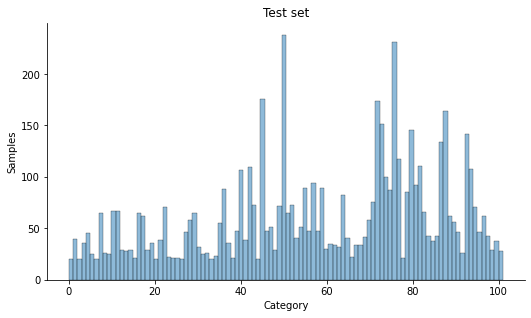

In [ ]:
distribuzione = sns.displot(train_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Training Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(val_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Validation Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(test_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Test set')
distribuzione.fig.set_size_inches(8,4)

In [ ]:
# Classi ordinate per numero di campioni
counts = df['Category'].value_counts()
idx = counts.index.tolist()
count_numbers_of_flowers_by_name = {}
for label_number in idx:
  x = counts[label_number]
  count_numbers_of_flowers_by_name[NAMES[int(label_number)]] = x

count_numbers_of_flowers_by_name = pd.DataFrame(count_numbers_of_flowers_by_name.items(), columns=['Category', 'Samples'])
display(count_numbers_of_flowers_by_name)

# TODO: convert this in csv or latex for documentation

,Category,Samples
0,petunia,258
1,passion flower,251
2,wallflower,196
3,water lily,194
4,watercress,184
...,...,...
97,moon orchid,40
98,bolero deep blue,40
99,mexican aster,40
100,pink primrose,40


## Osservazioni  
Come si può vedere dai grafici le classi nel training/Validation set sono perfettamente ben bilanciate.  
Putroppo però **il numero di campioni (10) per ogni classe è molto basso** per un task di classificazione basato sull'uso di CNN.  

Questo ci fa già riflettere su un  possibile approccio di **Data Augmentation** per poter far fronte a queste carenze di immagini di Training.

## Display Immagini

Ora mostriamo alcune immagini e vediamo come appaiono, per comodità mostriamo un numero ridotto di classi.

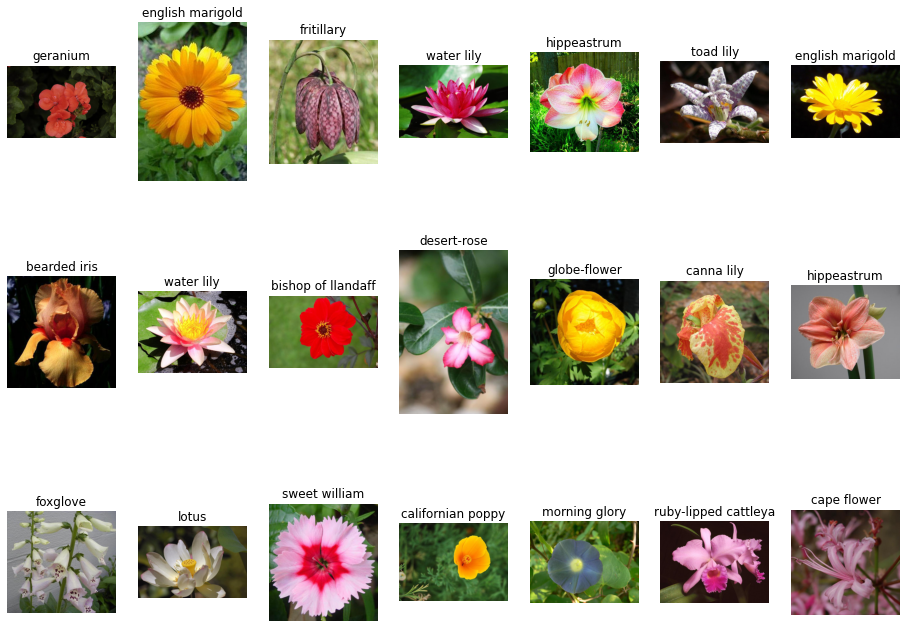

In [ ]:
plot_figure(df)

### Inter Class Similarity 
Osservando le immagini del data set originale abbiamo notato delle similarità tra classi di fiori diverse. Vediamo alcuni esempi:

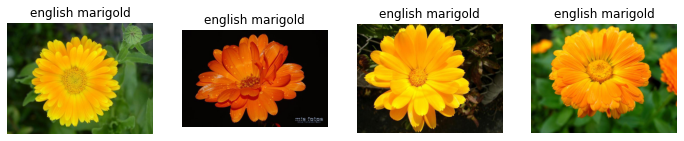

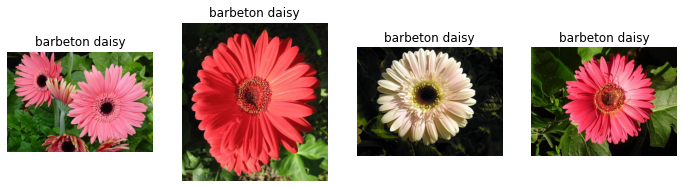

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["english marigold"]), plot_figure_by_class(df, NAMES_ID["barbeton daisy"])  

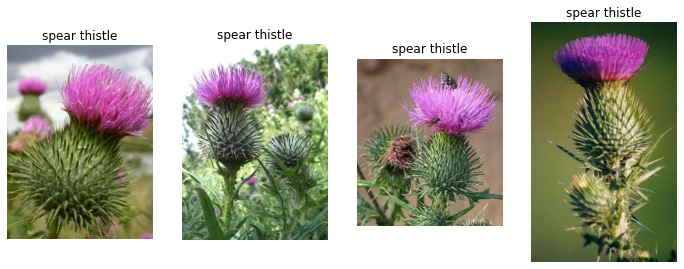

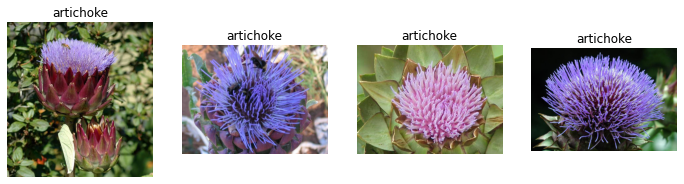

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["spear thistle"]), plot_figure_by_class(df, NAMES_ID["artichoke"]) 

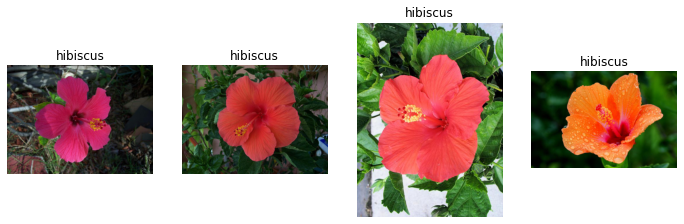

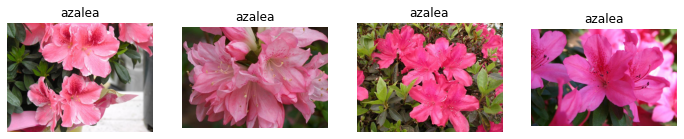

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["hibiscus"]), plot_figure_by_class(df, NAMES_ID["azalea"])  

### Osservazioni  
La presenza di similarità tra alcune classi è un'altro problema da affrontare.    
Avendo poche immagini di training e considerando le limitazioni del data augmentation su un dataset sensibile a possibili distorsioni cromatiche si potrebbe considerare di estrarre **feature handcrafted** dalle nostre immagini, come complemento ad altre possibili features.
(considerazioni da rivalutare se fine tuning)

# Preprocessing & Data Augmentation
Data augmentation artificially increases the size of the training set by
generating many realistic variants of each training instance. This
reduces overfitting, making this a regularization technique. The
generated instances should be as realistic as possible: ideally, given an
image from the augmented training set, a human should not be able to
tell whether it was augmented or not. Simply adding white noise will
not help; the modifications should be learnable (white noise is not).

For example, you can slightly shift, rotate, and resize every picture in
the training set by various amounts and add the resulting pictures to the
training set. This forces the model to be more
tolerant to variations in the position, orientation, and size of the objects
in the pictures. For a model that’s more tolerant of different lighting
conditions, you can similarly generate many images with various
contrasts. In general, you can also flip the pictures horizontally (except
for text, and other asymmetrical objects). By combining these
transformations, you can greatly increase the size of your training set.

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean
(similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. Each category’s representation would be learned during training. This is an example of representation learning

**Contrast Augmentation:**

LAB color space expresses color variations across three channels. One channel for brightness and two channels for color:
- L-channel: representing lightness in the image
- a-channel: representing change in color between red and green
- b-channel: representing change in color between yellow and blue

In the following adaptive histogram equalization id performed on the L-channel and the resulting image is converted back to RGB color space. This enhances the brightness while also limiting contrast sensitivity

In [12]:
def contrast_augmentation(img):

    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Stacking the original image with the enhanced image
    return np.hstack((img, enhanced_img))

In [13]:
from keras.preprocessing.image import ImageDataGenerator

def oversample(df, n, dir, img_size):
    
    tmp_df=df.copy()
    tmp_df["Id"] = dir+tmp_df["Id"]
    
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(rescale=1. / 255, 
                                rotation_range = 50,
                                shear_range=0.2,
                                zoom_range=[0.75,1.25],
                                brightness_range=[0.5, 1.5],
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True)
                                # preprocessing_function = contrast_augmentation)

    groups=tmp_df.groupby('Category') # group by class

    for label in tmp_df['Category'].unique():  # for every class               
        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        
        if sample_count< n: # if the class has less than target number of images
            
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images\n'.format(' ', str(label), str(delta))

            prefix = 'aug-'+str(label).zfill(3)+"-"

            # augmentation parameters
            # The second one, flow_from_dataframe will be very useful to us. 
            # It checks the path available on the dataframe and then automatically search for the image in train directory. 
            # Then it make the desired preprocessing steps available in ImageDataGenerator
            aug_gen=gen.flow_from_dataframe(group,  
                                            x_col='Id', y_col=None, 
                                            target_size=img_size,
                                            class_mode=None, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            save_to_dir=dir, 
                                            save_prefix=prefix, 
                                            color_mode='rgb',
                                            save_format='jpg')
            # print(msg, end='')
            
            # new images creation
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count

            # dataframe updating
            for file in os.listdir(dir):
                if file.startswith(prefix):
                    df.loc[df.index.max()+1] = [file, label]

    print('Total Augmented images created= ', total)
    return df

threshold=0
img_size=(224,224)
train_set = oversample(train_set, threshold, "/content/jpg/", img_size)

Total Augmented images created=  0


In [14]:
train_set

,Id,Category
6764,image_06765.jpg,0
6754,image_06755.jpg,0
6767,image_06768.jpg,0
6735,image_06736.jpg,0
6743,image_06744.jpg,0
...,...,...
8003,image_08004.jpg,101
8012,image_08013.jpg,101
8025,image_08026.jpg,101
8035,image_08036.jpg,101


In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
                                    # preprocessing_function = contrast_augmentation)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [16]:
# # converting back to string because CNNs need a categorical input
train_set['Category'] = train_set['Category'].astype(str)
test_set['Category']= test_set['Category'].astype(str)
val_set['Category'] = val_set['Category'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    # batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=True, 
    # seed=RANDOM_SEED,
    )

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    # batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=False, 
    # seed=RANDOM_SEED,
    )

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    directory=PATH_JPG,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    # batch_size=BATCH_SIZE, # 32 default
    class_mode='categorical',
    shuffle=False, 
    # seed=RANDOM_SEED,
    )

# train_generator, val_generator, test_generator

Found 1020 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.
Found 6149 validated image filenames belonging to 102 classes.


<ipython-input-16-53c09375ec40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Category'] = train_set['Category'].astype(str)
<ipython-input-16-53c09375ec40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Category']= test_set['Category'].astype(str)
<ipython-input-16-53c09375ec40>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

# Funzione Plot History model

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_history(history):
  fig = make_subplots(rows=1, cols=3, subplot_titles=["Loss", "Top-1 Accuracy", "Top-3 Accuracy"])

  fig.add_trace(
      go.Scatter(y=history.history['val_loss'], name="val_loss"),
      row = 1, col = 1
  )

  fig.add_trace(
      go.Scatter(y=history.history['loss'], name="train_loss"),
      row = 1, col = 1
  )

  fig.add_trace(
      go.Scatter(y=history.history['val_accuracy'], name="val_top-1_accuracy"),
      row = 1, col = 2
  )

  fig.add_trace(
      go.Scatter(y=history.history['accuracy'], name="train_top-1_accuracy"),
      row = 1, col = 2
  )

  fig.add_trace(
      go.Scatter(y=history.history['val_top_k_categorical_accuracy'], name="val_top-3_accuracy"),
      row = 1, col = 3
  )

  fig.add_trace(
      go.Scatter(y=history.history['top_k_categorical_accuracy'], name="train_top-3_accuracy"),
      row = 1, col = 3
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss", row=1, col=1)
  fig.update_yaxes(title_text="Top-1 Accuracy", row=1, col=2)
  fig.update_yaxes(title_text="Top-3 Accuracy", row=1, col=3)
  fig.show()

# Resnet50

In [28]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import top_k_accuracy_score

#Creazione modello

baseModel = ResNet50(weights='imagenet', include_top=True, input_shape= (224, 224, 3))
#baseModel.summary()

102967424/102967424 [==============================] - 5s 0us/step


In [29]:
# Freeze layer del baseModel
# con [:19] ottengo 84%
# con [:43] ottengo 82%
for layer in baseModel.layers:
	layer.trainable = False


# Nuova parte Fully Connected
model = Model(inputs=baseModel.input, outputs=baseModel.get_layer('avg_pool').output)
last_layer = baseModel.get_layer('avg_pool').output
last_layer = Flatten(name="flatten")(last_layer)
#last_layer = Dense(512, activation="relu")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model = Model(inputs=baseModel.input, outputs=last_layer)
#model.summary()

In [30]:
#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=["accuracy"]) 
model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

batch_size= 32
epochs=20
history = model.fit(train_generator,   batch_size=batch_size, epochs=epochs, validation_data=val_generator)

Epoch 1/20
32/32 [==============================] - 16s 419ms/step - loss: 4.2709 - accuracy: 0.1382 - top_k_categorical_accuracy: 0.2441 - val_loss: 2.6607 - val_accuracy: 0.4235 - val_top_k_categorical_accuracy: 0.6069
Epoch 2/20
32/32 [==============================] - 12s 372ms/step - loss: 1.5509 - accuracy: 0.7157 - top_k_categorical_accuracy: 0.8627 - val_loss: 1.6403 - val_accuracy: 0.6657 - val_top_k_categorical_accuracy: 0.8206
Epoch 3/20
32/32 [==============================] - 12s 370ms/step - loss: 0.7238 - accuracy: 0.9196 - top_k_categorical_accuracy: 0.9784 - val_loss: 1.2664 - val_accuracy: 0.7392 - val_top_k_categorical_accuracy: 0.8725
Epoch 4/20
32/32 [==============================] - 12s 370ms/step - loss: 0.3929 - accuracy: 0.9765 - top_k_categorical_accuracy: 0.9951 - val_loss: 1.0679 - val_accuracy: 0.7824 - val_top_k_categorical_accuracy: 0.9029
Epoch 5/20
32/32 [==============================] - 12s 369ms/step - loss: 0.2486 - accuracy: 0.9931 - top_k_categor

In [31]:
plot_history(history)

In [32]:
score = model.evaluate(test_generator) #evaluating the models accuracy or loss,
print('test loss, test acc:', score)

193/193 [==============================] - 36s 187ms/step - loss: 0.8567 - accuracy: 0.8009 - top_k_categorical_accuracy: 0.9014
test loss, test acc: [0.8567246794700623, 0.8009432554244995, 0.9014474153518677]


# ResNext101

In [33]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import top_k_accuracy_score


# Creazione Modello
!pip install git+https://github.com/qubvel/classification_models.git
from classification_models.keras import Classifiers
from classification_models.tfkeras import Classifiers
Classifiers.models_names()

ResNeXt101, preprocess_input = Classifiers.get('resnext101')
baseModel = ResNeXt101(include_top = True, input_shape=(224, 224, 3), weights='imagenet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-1u_wxvws
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-1u_wxvws
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [34]:
# Freeze layer del baseModel
for layer in baseModel.layers:
	layer.trainable = False


# Nuova parte Fully Connected - Fine Tuning
model = Model(inputs=baseModel.input, outputs=baseModel.get_layer('pool1').output)
last_layer = baseModel.get_layer('pool1').output
last_layer = Flatten(name="flatten")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model = Model(inputs=baseModel.input, outputs=last_layer)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_140 (ZeroPaddin  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                           

In [35]:
# train
batch_size= 32
epochs=20

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
history2 = model.fit(train_generator,   batch_size=batch_size, epochs=epochs, validation_data=val_generator)

Epoch 1/20
32/32 [==============================] - 85s 848ms/step - loss: 4.2650 - accuracy: 0.1147 - top_k_categorical_accuracy: 0.2275 - val_loss: 3.0488 - val_accuracy: 0.3843 - val_top_k_categorical_accuracy: 0.5637
Epoch 2/20
32/32 [==============================] - 18s 560ms/step - loss: 2.0333 - accuracy: 0.6833 - top_k_categorical_accuracy: 0.8373 - val_loss: 1.9550 - val_accuracy: 0.6382 - val_top_k_categorical_accuracy: 0.8088
Epoch 3/20
32/32 [==============================] - 18s 556ms/step - loss: 1.0715 - accuracy: 0.8922 - top_k_categorical_accuracy: 0.9637 - val_loss: 1.4199 - val_accuracy: 0.7647 - val_top_k_categorical_accuracy: 0.8882
Epoch 4/20
32/32 [==============================] - 18s 552ms/step - loss: 0.6474 - accuracy: 0.9461 - top_k_categorical_accuracy: 0.9873 - val_loss: 1.1767 - val_accuracy: 0.8010 - val_top_k_categorical_accuracy: 0.9049
Epoch 5/20
32/32 [==============================] - 18s 560ms/step - loss: 0.4254 - accuracy: 0.9794 - top_k_categor

In [36]:
plot_history(history2)

In [37]:
# Evaluation 
score = model.evaluate(test_generator) #evaluating the models accuracy or loss,
print('test loss, test acc:', score)

193/193 [==============================] - 54s 279ms/step - loss: 0.7523 - accuracy: 0.8266 - top_k_categorical_accuracy: 0.9192
test loss, test acc: [0.7523400187492371, 0.8266384601593018, 0.9191738367080688]


# ResNet50 - Fine Tuning from scratch





In [ ]:
for layer in baseModel.layers:
	layer.trainable = True


# Nuova parte Fully Connected
model50s = Model(inputs=baseModel.input, outputs=baseModel.get_layer('avg_pool').output)
last_layer = baseModel.get_layer('avg_pool').output
last_layer = Flatten(name="flatten")(last_layer)
#last_layer = Dense(512, activation="relu")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model50s = Model(inputs=baseModel.input, outputs=last_layer)
model50s.summary()

In [25]:
#model50s.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=["accuracy"]) 
model50s.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

batch_size= 32
epochs=30
history50s = model50s.fit(train_generator,   batch_size=batch_size, epochs=epochs, validation_data=val_generator)

Epoch 1/30
32/32 [==============================] - 25s 602ms/step - loss: 0.3960 - accuracy: 0.8951 - top_k_categorical_accuracy: 0.9775 - val_loss: 57.0152 - val_accuracy: 0.0245 - val_top_k_categorical_accuracy: 0.0647
Epoch 2/30
32/32 [==============================] - 18s 565ms/step - loss: 0.4226 - accuracy: 0.8902 - top_k_categorical_accuracy: 0.9725 - val_loss: 197.0816 - val_accuracy: 0.0167 - val_top_k_categorical_accuracy: 0.0549
Epoch 3/30
32/32 [==============================] - 18s 568ms/step - loss: 0.1877 - accuracy: 0.9588 - top_k_categorical_accuracy: 0.9941 - val_loss: 15.5984 - val_accuracy: 0.1373 - val_top_k_categorical_accuracy: 0.2588
Epoch 4/30
32/32 [==============================] - 18s 570ms/step - loss: 0.0528 - accuracy: 0.9873 - top_k_categorical_accuracy: 0.9971 - val_loss: 5.3412 - val_accuracy: 0.2892 - val_top_k_categorical_accuracy: 0.4853
Epoch 5/30
32/32 [==============================] - 18s 577ms/step - loss: 0.0315 - accuracy: 0.9922 - top_k_cat

In [27]:
plot_history(history50s)

In [29]:
score50s = model50s.evaluate(test_generator) #evaluating the models accuracy or loss,
print('test loss, test acc:', score50s)

193/193 [==============================] - 43s 220ms/step - loss: 1.3438 - accuracy: 0.6970 - top_k_categorical_accuracy: 0.8452
test loss, test acc: [1.343762755393982, 0.6970239281654358, 0.8451780676841736]


In [30]:
model50s.save("/content/gdrive/MyDrive/Progetto AML/Models/ResNet50_Scratch.h5")

# ResNext101 - Fine Tuning from scratch

In [ ]:
# Freeze layer del baseModel - Fine tuning dal 3 stage
for layer in model.layers:
        trainable_layer=True


# Nuova parte Fully Connected - Fine Tuning
model2 = Model(inputs=baseModel.input, outputs=baseModel.get_layer('pool1').output)
last_layer = baseModel.get_layer('pool1').output
last_layer = Flatten(name="flatten")(last_layer)
last_layer = Dense(102, activation="softmax")(last_layer)
model2 = Model(inputs=baseModel.input, outputs=last_layer)
model2.summary()

In [24]:
#model2.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=["accuracy"]) 
model2.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)])


epochs=30
history2 = model2.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/30
32/32 [==============================] - 123s 2s/step - loss: 3.9505 - accuracy: 0.1716 - top_k_categorical_accuracy: 0.3000 - val_loss: 57475.7305 - val_accuracy: 0.0098 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 49s 2s/step - loss: 1.9888 - accuracy: 0.4647 - top_k_categorical_accuracy: 0.6931 - val_loss: 12046.1367 - val_accuracy: 0.0147 - val_top_k_categorical_accuracy: 0.5284
Epoch 3/30
32/32 [==============================] - 48s 2s/step - loss: 1.1661 - accuracy: 0.6863 - top_k_categorical_accuracy: 0.8627 - val_loss: 11668.1641 - val_accuracy: 0.0510 - val_top_k_categorical_accuracy: 0.4569
Epoch 4/30
32/32 [==============================] - 48s 2s/step - loss: 0.7720 - accuracy: 0.7804 - top_k_categorical_accuracy: 0.9343 - val_loss: 17.2870 - val_accuracy: 0.0520 - val_top_k_categorical_accuracy: 0.1667
Epoch 5/30
32/32 [==============================] - 48s 2s/step - loss: 0.4462 - accuracy: 0.8627 - top_k_categori

In [25]:
plot_history(history2)

In [26]:
score2 = model2.evaluate(test_generator)

193/193 [==============================] - 54s 278ms/step - loss: 2.0200 - accuracy: 0.5942 - top_k_categorical_accuracy: 0.7694


In [27]:
model2.save("/content/gdrive/MyDrive/Progetto AML/Models/ResNext101_Scratch.h5")